# Trading Strategy

Using the AE and LSTM models that were trained and evaluated in previous steps, a trading strategy can be developed using the same data sets. 

The steps will be as follows: 
- Using the AE model, the most representative company(s) will be identified over a 5 year time period
- The one month performance will be predicted using the previous 3 months data
- The one month performance of the S&P 500 will also be predicted using the previous 3 months
- If the company performance is expected to perform better than the S&P 500, a long position in the company and a short position in the S&P 500 index will be taken. And vice-versa. 
- The performance of the strategy will be measured against the S&P 500 performance? 

## Libraries 

In [77]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import ast
import pickle
from datetime import datetime, timedelta
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score

## Data Import and Preprocessing

The same datasets will be used: 
- The share price data for the S&P 500 constituents, 
- and the S&P 500 itself
- The analyst estimates data for the S&P 500 constituents
- The index constituents data per month 
- The mapping table to convert ISIN to RIC to Common Company Name


In [2]:
## import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

## import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

## import the IBES analysts estimates data
estimates_df = pd.read_csv(
        '../Data/eikon_ibes_data_1995.csv',
        index_col = 0,
        parse_dates = True, 
)#.fillna(method = 'ffill').dropna(axis = 1, how = 'any')

In [3]:
## consistent date range across the time-series data
s_date = '1995-02-01'
e_date = '2000-01-31'

prices_df = prices_df.loc[s_date:e_date, :]
spx_df = spx_df.loc[s_date:e_date, :]
estimates_df = estimates_df.loc[s_date:e_date, :]

Its always useful to visually inspect the test data set first. This time period shows a general positive trend with a few periods of volatility. There is perhaps more volatility towards the end of the period, so it will be interesting to see how the model performs. 

The test period of 5 years was deemed to be suitable considering the autoencoder constraints discussed below and in previous chapters regarding missing values. At 5 years, there is a decent period of information for a model to indentify some latent relationships in training. It is also not too long that it means that too many important companies with shorter existence will be excluded. 

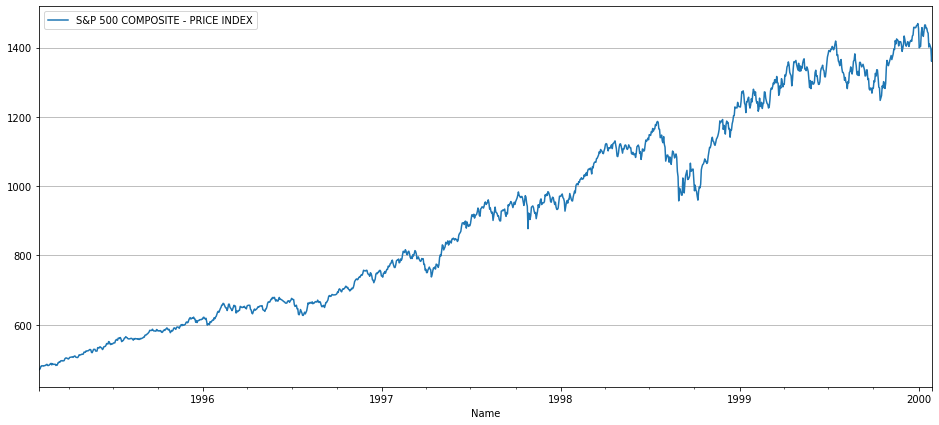

In [4]:
spx_df.plot(figsize = (16, 7))
plt.grid(axis = 'y');

In [5]:
## formatting the column titles for estimates_df
estimates_df.columns = [
    'RIC',
    'Number of Analysts', 
    'Earnings Per Share FY0 - Actual',
    'Earnings Per Share FY0 - Mean', 
    'Earnings Per Share FY1 - Mean',
    'Earnings Per Share FY2 - Mean', 
    'Earnings Per Share FQ0 - Actual',
    'Earnings Per Share FQ0 - Mean', 
    'Earnings Per Share FQ1 - Mean',
    'Earnings Per Share FQ2 - Mean', 
    'Earnings Per Share FQ3 - Mean',
    'Earnings Per Share FQ4 - Mean'
]

Additional datasets will need to be created:
- S&P 500 constituents share price returns
- S&P 500 index returns 

In [6]:
returns_df = prices_df.pct_change()
returns_df.iloc[0, :] = 0

spx_returns_df = spx_df.pct_change()
spx_returns_df.iloc[0, :] = 0

For the `prices_df` and `returns_df` dataframes, the values for companies that were not members of the S&P 500 index at a given period will be changed to NaN values. Before the autoencoder is trained, only companies that have no NaN values over the entire period under examination will be considered. This is due to the issues that the autoencoder model faces when learning on a dataset containing several NaN values. These companies can easily be dropped from the dataframe if the value is NaN

In [7]:
## create a monthly date range to access index constituents form constituents_df
dates = pd.date_range(s_date, e_date, freq = 'BM').strftime('%Y-%m')

for month in dates: 
    constituents = constituents_df.loc[month, 'Index Constituents'].values[0]
    isin_codes = map_df.loc[constituents, 'ISIN'].values
    not_in_index = [company for company in prices_df[month].columns if company not in isin_codes]
    prices_df.loc[month, not_in_index] = np.nan
    returns_df.loc[month, not_in_index] = np.nan

# The autoencoder 

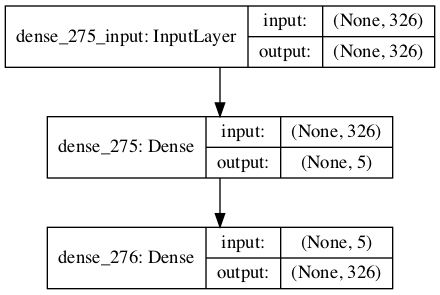

In [8]:
ae_model = load_model('model/ae_model_wo_reg_2020_08_27.h5')

# keras.utils.vis_utils.pydot
plot_model(ae_model, to_file = 'images/ae_model.png', show_shapes = True,)# show_layer_names = True)

The number of companies and the specific companies are likely to change at each moving window, so we are unable to use the exact model trained previously. Instead, at each time period (monthly) the weights will be retrained. The hyperparameters used to train the original model can be used on each new model. They are as follows: 

`{'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (5,)}`

In [9]:
def create_model(
    n_companies,
    n_nodes_list = (5,), 
    penalty = 0.0, 
    act_funct = 'relu', 
    lr = 0.0001, 
):
    
    model = Sequential()
    i = 0
    
    for layer in n_nodes_list:
        if i == 0:
            model.add(Dense(
                layer, 
                activation = act_funct, 
                kernel_regularizer = regularizers.l2(penalty),
                input_shape = (n_companies, )
                     ))
        else:
            model.add(Dense(
                n_nodes_list[layer], 
                activation = act_funct,
                kernel_regularizer = regularizers.l2(penalty)      
                     ))
        i += 0
    
    opt = Adam(learning_rate = lr)
    model.add(Dense(n_companies, activation = 'linear', kernel_regularizer = regularizers.l2(penalty)))
    model.compile(optimizer = opt, loss = 'mse')
    
    return model

This means that a new autoencoder will need to be trained for every month. These models will be trained and stored in the dictionary `ae_models_dict` with the keys relating to the month the LSTM model will be trying to predict. So if the LSTM was trying to predict the returns for 01-2016, the autoencoder for that will be using returns data from 01-01-2010 to 31-12-2015.

In [10]:
import_ae_models_dict = False

if import_ae_models_dict:
    
    filename = 'model/ae_models_dict_2020_08_28.pkl' # or change the date

    infile = open(filename,'rb')
    ae_models_dict = pickle.load(infile)
    infile.close()
    
else:

    ae_models_dict = {}
    early_stopping = EarlyStopping(monitor = 'loss', patience = 5)

    for m in range(len(dates[:-48])):

        # get the data for the preceeding 60 month period and drop companies with any NaN values
        df = copy.deepcopy(returns_df[dates[m]:dates[m+47]])
        df = df.dropna(axis = 1, how = 'any').astype('float32')

        # compile and fit the autoencoder
        n_companies = df.shape[1]
        ae_model = create_model(n_companies)
        ae_model.fit(
            df, 
            df, 
            shuffle = False, 
            batch_size = 5,
            epochs = 500,
            callbacks = [early_stopping]
        )

        # predict the reconstructed data
        recon_df = pd.DataFrame(
            ae_model.predict(df), 
            index = df.index, 
            columns = df.columns
        )
        
        # create a dataframe with the reconstruction errors per company
        mse_df = pd.DataFrame()
        for co in df.columns:
            mse_df.loc[co, 'mse'] = mean_squared_error(df[co], recon_df[co])

        ae_models_dict[dates[m+48]] = ae_model, recon_df, mse_df

Epoch 1/500
1043/1043 [==============================] - 0s 214us/step - loss: 3.7652e-04
Epoch 2/500
1043/1043 [==============================] - 0s 121us/step - loss: 3.7385e-04
Epoch 3/500
1043/1043 [==============================] - 0s 142us/step - loss: 3.7265e-04
Epoch 4/500
1043/1043 [==============================] - 0s 119us/step - loss: 3.7095e-04
Epoch 5/500
1043/1043 [==============================] - 0s 128us/step - loss: 3.6652e-04
Epoch 6/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.5789e-04
Epoch 7/500
1043/1043 [==============================] - 0s 119us/step - loss: 3.4706e-04
Epoch 8/500
1043/1043 [==============================] - 0s 119us/step - loss: 3.3701e-04
Epoch 9/500
1043/1043 [==============================] - 0s 137us/step - loss: 3.2884e-04
Epoch 10/500
1043/1043 [==============================] - 0s 134us/step - loss: 3.2253e-04
Epoch 11/500
1043/1043 [==============================] - 0s 137us/step - loss: 3.1772e-04
Epoch 12

1043/1043 [==============================] - 0s 120us/step - loss: 2.6838e-04
Epoch 92/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6831e-04
Epoch 93/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.6824e-04
Epoch 94/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6817e-04
Epoch 95/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.6810e-04
Epoch 96/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6803e-04
Epoch 97/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6797e-04
Epoch 98/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.6790e-04
Epoch 99/500
1043/1043 [==============================] - 0s 116us/step - loss: 2.6784e-04
Epoch 100/500
1043/1043 [==============================] - 0s 117us/step - loss: 2.6778e-04
Epoch 101/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6773e-04
Epoch 102/

1043/1043 [==============================] - 0s 115us/step - loss: 2.6541e-04
Epoch 270/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6541e-04
Epoch 271/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.6541e-04
Epoch 272/500
1043/1043 [==============================] - 0s 111us/step - loss: 2.6540e-04
Epoch 273/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6540e-04
Epoch 274/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.6540e-04
Epoch 275/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.6540e-04
Epoch 276/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6540e-04
Epoch 277/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.6539e-04
Epoch 278/500
1043/1043 [==============================] - 0s 111us/step - loss: 2.6539e-04
Epoch 279/500
1043/1043 [==============================] - 0s 117us/step - loss: 2.6539e-04
Ep

1043/1043 [==============================] - 0s 119us/step - loss: 2.6524e-04
Epoch 448/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.6524e-04
Epoch 449/500
1043/1043 [==============================] - 0s 126us/step - loss: 2.6524e-04
Epoch 450/500
1043/1043 [==============================] - 0s 125us/step - loss: 2.6524e-04
Epoch 451/500
1043/1043 [==============================] - 0s 124us/step - loss: 2.6524e-04
Epoch 452/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.6524e-04
Epoch 453/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.6524e-04
Epoch 454/500
1043/1043 [==============================] - 0s 123us/step - loss: 2.6524e-04
Epoch 455/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.6523e-04
Epoch 456/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.6523e-04
Epoch 457/500
1043/1043 [==============================] - 0s 121us/step - loss: 2.6523e-04
Ep

1043/1043 [==============================] - 0s 117us/step - loss: 2.7413e-04
Epoch 126/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.7409e-04
Epoch 127/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.7405e-04
Epoch 128/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7401e-04
Epoch 129/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7397e-04
Epoch 130/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.7393e-04
Epoch 131/500
1043/1043 [==============================] - 0s 119us/step - loss: 2.7389e-04
Epoch 132/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.7386e-04
Epoch 133/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7382e-04
Epoch 134/500
1043/1043 [==============================] - 0s 116us/step - loss: 2.7379e-04
Epoch 135/500
1043/1043 [==============================] - 0s 111us/step - loss: 2.7376e-04
Ep

1043/1043 [==============================] - 0s 118us/step - loss: 2.7213e-04
Epoch 304/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7213e-04
Epoch 305/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7213e-04
Epoch 306/500
1043/1043 [==============================] - 0s 120us/step - loss: 2.7213e-04
Epoch 307/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7212e-04
Epoch 308/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7212e-04
Epoch 309/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7212e-04
Epoch 310/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7211e-04
Epoch 311/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7211e-04
Epoch 312/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7211e-04
Epoch 313/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7210e-04
Ep

1043/1043 [==============================] - 0s 120us/step - loss: 2.7174e-04
Epoch 482/500
1043/1043 [==============================] - 0s 111us/step - loss: 2.7174e-04
Epoch 483/500
1043/1043 [==============================] - 0s 133us/step - loss: 2.7174e-04
Epoch 484/500
1043/1043 [==============================] - 0s 126us/step - loss: 2.7174e-04
Epoch 485/500
1043/1043 [==============================] - 0s 132us/step - loss: 2.7173e-04
Epoch 486/500
1043/1043 [==============================] - 0s 132us/step - loss: 2.7173e-04
Epoch 487/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7173e-04
Epoch 488/500
1043/1043 [==============================] - 0s 126us/step - loss: 2.7173e-04
Epoch 489/500
1043/1043 [==============================] - 0s 139us/step - loss: 2.7173e-04
Epoch 490/500
1043/1043 [==============================] - 0s 121us/step - loss: 2.7173e-04
Epoch 491/500
1043/1043 [==============================] - 0s 124us/step - loss: 2.7173e-04
Ep

1043/1043 [==============================] - 0s 111us/step - loss: 2.8608e-04
Epoch 72/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.8582e-04
Epoch 73/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.8558e-04
Epoch 74/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.8534e-04
Epoch 75/500
1043/1043 [==============================] - 0s 110us/step - loss: 2.8512e-04
Epoch 76/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.8492e-04
Epoch 77/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.8472e-04
Epoch 78/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.8453e-04
Epoch 79/500
1043/1043 [==============================] - 0s 109us/step - loss: 2.8435e-04
Epoch 80/500
1043/1043 [==============================] - 0s 110us/step - loss: 2.8419e-04
Epoch 81/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.8403e-04
Epoch 82/500

1043/1043 [==============================] - 0s 119us/step - loss: 2.7920e-04
Epoch 250/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7919e-04
Epoch 251/500
1043/1043 [==============================] - 0s 117us/step - loss: 2.7919e-04
Epoch 252/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7918e-04
Epoch 253/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7918e-04
Epoch 254/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7917e-04
Epoch 255/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7917e-04
Epoch 256/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7916e-04
Epoch 257/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7916e-04
Epoch 258/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7915e-04
Epoch 259/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.7915e-04
Ep

1043/1043 [==============================] - 0s 121us/step - loss: 2.7871e-04
Epoch 428/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7870e-04
Epoch 429/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7870e-04
Epoch 430/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7870e-04
Epoch 431/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.7870e-04
Epoch 432/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7870e-04
Epoch 433/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7870e-04
Epoch 434/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.7870e-04
Epoch 435/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.7869e-04
Epoch 436/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7869e-04
Epoch 437/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.7869e-04
Ep

1045/1045 [==============================] - 0s 113us/step - loss: 2.9199e-04
Epoch 107/500
1045/1045 [==============================] - 0s 113us/step - loss: 2.9187e-04
Epoch 108/500
1045/1045 [==============================] - 0s 110us/step - loss: 2.9175e-04
Epoch 109/500
1045/1045 [==============================] - 0s 109us/step - loss: 2.9163e-04
Epoch 110/500
1045/1045 [==============================] - 0s 110us/step - loss: 2.9151e-04
Epoch 111/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.9140e-04
Epoch 112/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.9129e-04
Epoch 113/500
1045/1045 [==============================] - 0s 110us/step - loss: 2.9119e-04
Epoch 114/500
1045/1045 [==============================] - 0s 110us/step - loss: 2.9108e-04
Epoch 115/500
1045/1045 [==============================] - 0s 115us/step - loss: 2.9098e-04
Epoch 116/500
1045/1045 [==============================] - 0s 114us/step - loss: 2.9088e-04
Ep

1045/1045 [==============================] - 0s 116us/step - loss: 2.8670e-04
Epoch 285/500
1045/1045 [==============================] - 0s 113us/step - loss: 2.8670e-04
Epoch 286/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.8669e-04
Epoch 287/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.8669e-04
Epoch 288/500
1045/1045 [==============================] - 0s 117us/step - loss: 2.8669e-04
Epoch 289/500
1045/1045 [==============================] - 0s 117us/step - loss: 2.8668e-04
Epoch 290/500
1045/1045 [==============================] - 0s 115us/step - loss: 2.8668e-04
Epoch 291/500
1045/1045 [==============================] - 0s 113us/step - loss: 2.8668e-04
Epoch 292/500
1045/1045 [==============================] - 0s 115us/step - loss: 2.8668e-04
Epoch 293/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.8667e-04
Epoch 294/500
1045/1045 [==============================] - 0s 113us/step - loss: 2.8667e-04
Ep

1045/1045 [==============================] - 0s 112us/step - loss: 2.8645e-04
Epoch 463/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.8645e-04
Epoch 464/500
1045/1045 [==============================] - 0s 114us/step - loss: 2.8645e-04
Epoch 465/500
1045/1045 [==============================] - 0s 111us/step - loss: 2.8645e-04
Epoch 466/500
1045/1045 [==============================] - 0s 110us/step - loss: 2.8645e-04
Epoch 467/500
1045/1045 [==============================] - 0s 112us/step - loss: 2.8645e-04
Epoch 468/500
1045/1045 [==============================] - 0s 110us/step - loss: 2.8645e-04
Epoch 469/500
1045/1045 [==============================] - 0s 111us/step - loss: 2.8645e-04
Epoch 470/500
1045/1045 [==============================] - 0s 111us/step - loss: 2.8645e-04
Epoch 471/500
1045/1045 [==============================] - 0s 117us/step - loss: 2.8645e-04
Epoch 472/500
1045/1045 [==============================] - 0s 117us/step - loss: 2.8645e-04
Ep

1043/1043 [==============================] - 0s 115us/step - loss: 2.9190e-04
Epoch 141/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9188e-04
Epoch 142/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.9187e-04
Epoch 143/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9185e-04
Epoch 144/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.9184e-04
Epoch 145/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9182e-04
Epoch 146/500
1043/1043 [==============================] - 0s 121us/step - loss: 2.9181e-04
Epoch 147/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.9179e-04
Epoch 148/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9178e-04
Epoch 149/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.9177e-04
Epoch 150/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9175e-04
Ep

1043/1043 [==============================] - 0s 114us/step - loss: 2.9099e-04
Epoch 319/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9099e-04
Epoch 320/500
1043/1043 [==============================] - 0s 116us/step - loss: 2.9099e-04
Epoch 321/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9099e-04
Epoch 322/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9099e-04
Epoch 323/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9098e-04
Epoch 324/500
1043/1043 [==============================] - 0s 111us/step - loss: 2.9098e-04
Epoch 325/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.9098e-04
Epoch 326/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9098e-04
Epoch 327/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9098e-04
Epoch 328/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.9098e-04
Ep

1043/1043 [==============================] - 0s 114us/step - loss: 2.9078e-04
Epoch 497/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9078e-04
Epoch 498/500
1043/1043 [==============================] - 0s 112us/step - loss: 2.9078e-04
Epoch 499/500
1043/1043 [==============================] - 0s 109us/step - loss: 2.9078e-04
Epoch 500/500
1043/1043 [==============================] - 0s 110us/step - loss: 2.9078e-04
Epoch 1/500
1043/1043 [==============================] - 0s 190us/step - loss: 4.2128e-04
Epoch 2/500
1043/1043 [==============================] - 0s 114us/step - loss: 4.1813e-04
Epoch 3/500
1043/1043 [==============================] - 0s 113us/step - loss: 4.1661e-04
Epoch 4/500
1043/1043 [==============================] - 0s 126us/step - loss: 4.1479e-04
Epoch 5/500
1043/1043 [==============================] - 0s 109us/step - loss: 4.1026e-04
Epoch 6/500
1043/1043 [==============================] - 0s 118us/step - loss: 4.0075e-04
Epoch 7/500
10

1043/1043 [==============================] - 0s 117us/step - loss: 2.9833e-04
Epoch 176/500
1043/1043 [==============================] - 0s 116us/step - loss: 2.9830e-04
Epoch 177/500
1043/1043 [==============================] - 0s 116us/step - loss: 2.9827e-04
Epoch 178/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9825e-04
Epoch 179/500
1043/1043 [==============================] - 0s 126us/step - loss: 2.9822e-04
Epoch 180/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.9819e-04
Epoch 181/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9816e-04
Epoch 182/500
1043/1043 [==============================] - 0s 119us/step - loss: 2.9814e-04
Epoch 183/500
1043/1043 [==============================] - 0s 114us/step - loss: 2.9811e-04
Epoch 184/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9808e-04
Epoch 185/500
1043/1043 [==============================] - 0s 113us/step - loss: 2.9806e-04
Ep

1043/1043 [==============================] - 0s 125us/step - loss: 2.9610e-04
Epoch 354/500
1043/1043 [==============================] - 0s 126us/step - loss: 2.9609e-04
Epoch 355/500
1043/1043 [==============================] - 0s 121us/step - loss: 2.9609e-04
Epoch 356/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.9608e-04
Epoch 357/500
1043/1043 [==============================] - 0s 123us/step - loss: 2.9608e-04
Epoch 358/500
1043/1043 [==============================] - 0s 126us/step - loss: 2.9608e-04
Epoch 359/500
1043/1043 [==============================] - 0s 118us/step - loss: 2.9607e-04
Epoch 360/500
1043/1043 [==============================] - 0s 125us/step - loss: 2.9607e-04
Epoch 361/500
1043/1043 [==============================] - 0s 122us/step - loss: 2.9606e-04
Epoch 362/500
1043/1043 [==============================] - 0s 124us/step - loss: 2.9606e-04
Epoch 363/500
1043/1043 [==============================] - 0s 115us/step - loss: 2.9606e-04
Ep

1044/1044 [==============================] - 0s 118us/step - loss: 3.2960e-04
Epoch 32/500
1044/1044 [==============================] - 0s 109us/step - loss: 3.2860e-04
Epoch 33/500
1044/1044 [==============================] - 0s 112us/step - loss: 3.2764e-04
Epoch 34/500
1044/1044 [==============================] - 0s 113us/step - loss: 3.2671e-04
Epoch 35/500
1044/1044 [==============================] - 0s 109us/step - loss: 3.2581e-04
Epoch 36/500
1044/1044 [==============================] - 0s 108us/step - loss: 3.2494e-04
Epoch 37/500
1044/1044 [==============================] - 0s 114us/step - loss: 3.2411e-04
Epoch 38/500
1044/1044 [==============================] - 0s 121us/step - loss: 3.2330e-04
Epoch 39/500
1044/1044 [==============================] - 0s 118us/step - loss: 3.2252e-04
Epoch 40/500
1044/1044 [==============================] - 0s 112us/step - loss: 3.2178e-04
Epoch 41/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.2105e-04
Epoch 42/500

Epoch 121/500
1044/1044 [==============================] - 0s 114us/step - loss: 3.0341e-04
Epoch 122/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.0336e-04
Epoch 123/500
1044/1044 [==============================] - 0s 116us/step - loss: 3.0331e-04
Epoch 124/500
1044/1044 [==============================] - 0s 112us/step - loss: 3.0326e-04
Epoch 125/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.0321e-04
Epoch 126/500
1044/1044 [==============================] - 0s 113us/step - loss: 3.0316e-04
Epoch 127/500
1044/1044 [==============================] - 0s 113us/step - loss: 3.0311e-04
Epoch 128/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.0307e-04
Epoch 129/500
1044/1044 [==============================] - 0s 112us/step - loss: 3.0302e-04
Epoch 130/500
1044/1044 [==============================] - 0s 112us/step - loss: 3.0297e-04
Epoch 131/500
1044/1044 [==============================] - 0s 114us/step - loss:

1044/1044 [==============================] - 0s 116us/step - loss: 3.0007e-04
Epoch 211/500
1044/1044 [==============================] - 0s 116us/step - loss: 3.0005e-04
Epoch 212/500
1044/1044 [==============================] - 0s 113us/step - loss: 3.0003e-04
Epoch 213/500
1044/1044 [==============================] - 0s 112us/step - loss: 3.0001e-04
Epoch 214/500
1044/1044 [==============================] - 0s 115us/step - loss: 2.9998e-04
Epoch 215/500
1044/1044 [==============================] - 0s 116us/step - loss: 2.9996e-04
Epoch 216/500
1044/1044 [==============================] - 0s 112us/step - loss: 2.9994e-04
Epoch 217/500
1044/1044 [==============================] - 0s 115us/step - loss: 2.9992e-04
Epoch 218/500
1044/1044 [==============================] - 0s 113us/step - loss: 2.9990e-04
Epoch 219/500
1044/1044 [==============================] - 0s 114us/step - loss: 2.9988e-04
Epoch 220/500
1044/1044 [==============================] - 0s 132us/step - loss: 2.9986e-04
Ep

1044/1044 [==============================] - 0s 116us/step - loss: 2.9863e-04
Epoch 389/500
1044/1044 [==============================] - 0s 116us/step - loss: 2.9863e-04
Epoch 390/500
1044/1044 [==============================] - 0s 115us/step - loss: 2.9863e-04
Epoch 391/500
1044/1044 [==============================] - 0s 115us/step - loss: 2.9863e-04
Epoch 392/500
1044/1044 [==============================] - 0s 119us/step - loss: 2.9862e-04
Epoch 393/500
1044/1044 [==============================] - 0s 119us/step - loss: 2.9862e-04
Epoch 394/500
1044/1044 [==============================] - 0s 123us/step - loss: 2.9862e-04
Epoch 395/500
1044/1044 [==============================] - 0s 118us/step - loss: 2.9862e-04
Epoch 396/500
1044/1044 [==============================] - 0s 123us/step - loss: 2.9862e-04
Epoch 397/500
1044/1044 [==============================] - 0s 124us/step - loss: 2.9861e-04
Epoch 398/500
1044/1044 [==============================] - 0s 121us/step - loss: 2.9861e-04
Ep

1043/1043 [==============================] - 0s 123us/step - loss: 3.1241e-04
Epoch 68/500
1043/1043 [==============================] - 0s 117us/step - loss: 3.1214e-04
Epoch 69/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.1187e-04
Epoch 70/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.1161e-04
Epoch 71/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.1136e-04
Epoch 72/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.1112e-04
Epoch 73/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.1089e-04
Epoch 74/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.1066e-04
Epoch 75/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.1044e-04
Epoch 76/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.1023e-04
Epoch 77/500
1043/1043 [==============================] - 0s 115us/step - loss: 3.1003e-04
Epoch 78/500

1043/1043 [==============================] - 0s 122us/step - loss: 3.0382e-04
Epoch 246/500
1043/1043 [==============================] - 0s 121us/step - loss: 3.0382e-04
Epoch 247/500
1043/1043 [==============================] - 0s 124us/step - loss: 3.0382e-04
Epoch 248/500
1043/1043 [==============================] - 0s 126us/step - loss: 3.0382e-04
Epoch 249/500
1043/1043 [==============================] - 0s 130us/step - loss: 3.0382e-04
Epoch 250/500
1043/1043 [==============================] - 0s 128us/step - loss: 3.0381e-04
Epoch 251/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.0381e-04
Epoch 252/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.0381e-04
Epoch 253/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.0381e-04
Epoch 254/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.0381e-04
Epoch 255/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.0380e-04
Ep

1043/1043 [==============================] - 0s 124us/step - loss: 3.0366e-04
Epoch 424/500
1043/1043 [==============================] - 0s 113us/step - loss: 3.0366e-04
Epoch 425/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.0366e-04
Epoch 426/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.0366e-04
Epoch 427/500
1043/1043 [==============================] - 0s 113us/step - loss: 3.0366e-04
Epoch 428/500
1043/1043 [==============================] - 0s 122us/step - loss: 3.0366e-04
Epoch 429/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.0366e-04
Epoch 430/500
1043/1043 [==============================] - 0s 111us/step - loss: 3.0366e-04
Epoch 431/500
1043/1043 [==============================] - 0s 128us/step - loss: 3.0366e-04
Epoch 432/500
1043/1043 [==============================] - 0s 128us/step - loss: 3.0366e-04
Epoch 433/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.0366e-04
Ep

1044/1044 [==============================] - 0s 117us/step - loss: 3.1317e-04
Epoch 103/500
1044/1044 [==============================] - 0s 122us/step - loss: 3.1305e-04
Epoch 104/500
1044/1044 [==============================] - 0s 115us/step - loss: 3.1292e-04
Epoch 105/500
1044/1044 [==============================] - 0s 113us/step - loss: 3.1280e-04
Epoch 106/500
1044/1044 [==============================] - 0s 117us/step - loss: 3.1268e-04
Epoch 107/500
1044/1044 [==============================] - 0s 114us/step - loss: 3.1257e-04
Epoch 108/500
1044/1044 [==============================] - 0s 113us/step - loss: 3.1246e-04
Epoch 109/500
1044/1044 [==============================] - 0s 116us/step - loss: 3.1236e-04
Epoch 110/500
1044/1044 [==============================] - 0s 115us/step - loss: 3.1225e-04
Epoch 111/500
1044/1044 [==============================] - 0s 114us/step - loss: 3.1215e-04
Epoch 112/500
1044/1044 [==============================] - 0s 119us/step - loss: 3.1206e-04
Ep

1044/1044 [==============================] - 0s 141us/step - loss: 3.0908e-04
Epoch 281/500
1044/1044 [==============================] - 0s 128us/step - loss: 3.0908e-04
Epoch 282/500
1044/1044 [==============================] - 0s 132us/step - loss: 3.0908e-04
Epoch 283/500
1044/1044 [==============================] - 0s 118us/step - loss: 3.0908e-04
Epoch 284/500
1044/1044 [==============================] - 0s 116us/step - loss: 3.0907e-04
Epoch 285/500
1044/1044 [==============================] - 0s 122us/step - loss: 3.0907e-04
Epoch 286/500
1044/1044 [==============================] - 0s 122us/step - loss: 3.0907e-04
Epoch 287/500
1044/1044 [==============================] - 0s 118us/step - loss: 3.0907e-04
Epoch 288/500
1044/1044 [==============================] - 0s 133us/step - loss: 3.0907e-04
Epoch 289/500
1044/1044 [==============================] - 0s 124us/step - loss: 3.0907e-04
Epoch 290/500
1044/1044 [==============================] - 0s 117us/step - loss: 3.0907e-04
Ep

1044/1044 [==============================] - 0s 115us/step - loss: 3.0900e-04
Epoch 459/500
1044/1044 [==============================] - 0s 115us/step - loss: 3.0900e-04
Epoch 460/500
1044/1044 [==============================] - 0s 109us/step - loss: 3.0900e-04
Epoch 461/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.0900e-04
Epoch 462/500
1044/1044 [==============================] - 0s 108us/step - loss: 3.0900e-04
Epoch 463/500
1044/1044 [==============================] - 0s 109us/step - loss: 3.0900e-04
Epoch 464/500
1044/1044 [==============================] - 0s 109us/step - loss: 3.0900e-04
Epoch 465/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.0900e-04
Epoch 466/500
1044/1044 [==============================] - 0s 109us/step - loss: 3.0900e-04
Epoch 467/500
1044/1044 [==============================] - 0s 111us/step - loss: 3.0900e-04
Epoch 468/500
1044/1044 [==============================] - 0s 114us/step - loss: 3.0900e-04
Ep

1043/1043 [==============================] - 0s 123us/step - loss: 3.2030e-04
Epoch 137/500
1043/1043 [==============================] - 0s 125us/step - loss: 3.2025e-04
Epoch 138/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.2020e-04
Epoch 139/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.2016e-04
Epoch 140/500
1043/1043 [==============================] - 0s 121us/step - loss: 3.2011e-04
Epoch 141/500
1043/1043 [==============================] - 0s 121us/step - loss: 3.2007e-04
Epoch 142/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.2003e-04
Epoch 143/500
1043/1043 [==============================] - 0s 123us/step - loss: 3.1999e-04
Epoch 144/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.1995e-04
Epoch 145/500
1043/1043 [==============================] - 0s 124us/step - loss: 3.1991e-04
Epoch 146/500
1043/1043 [==============================] - 0s 117us/step - loss: 3.1987e-04
Ep

1043/1043 [==============================] - 0s 121us/step - loss: 3.1765e-04
Epoch 315/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.1764e-04
Epoch 316/500
1043/1043 [==============================] - 0s 115us/step - loss: 3.1764e-04
Epoch 317/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.1763e-04
Epoch 318/500
1043/1043 [==============================] - 0s 119us/step - loss: 3.1763e-04
Epoch 319/500
1043/1043 [==============================] - 0s 123us/step - loss: 3.1762e-04
Epoch 320/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.1762e-04
Epoch 321/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.1761e-04
Epoch 322/500
1043/1043 [==============================] - 0s 113us/step - loss: 3.1761e-04
Epoch 323/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.1760e-04
Epoch 324/500
1043/1043 [==============================] - 0s 123us/step - loss: 3.1760e-04
Ep

1043/1043 [==============================] - 0s 129us/step - loss: 3.1693e-04
Epoch 493/500
1043/1043 [==============================] - 0s 129us/step - loss: 3.1693e-04
Epoch 494/500
1043/1043 [==============================] - 0s 110us/step - loss: 3.1693e-04
Epoch 495/500
1043/1043 [==============================] - 0s 111us/step - loss: 3.1692e-04
Epoch 496/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.1692e-04
Epoch 497/500
1043/1043 [==============================] - 0s 110us/step - loss: 3.1692e-04
Epoch 498/500
1043/1043 [==============================] - 0s 109us/step - loss: 3.1691e-04
Epoch 499/500
1043/1043 [==============================] - 0s 109us/step - loss: 3.1691e-04
Epoch 500/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.1691e-04
Epoch 1/500
1043/1043 [==============================] - 0s 184us/step - loss: 4.5701e-04
Epoch 2/500
1043/1043 [==============================] - 0s 114us/step - loss: 4.5350e-04
Epoch 

1043/1043 [==============================] - 0s 116us/step - loss: 3.2175e-04
Epoch 172/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.2172e-04
Epoch 173/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.2170e-04
Epoch 174/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.2168e-04
Epoch 175/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.2166e-04
Epoch 176/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.2163e-04
Epoch 177/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.2161e-04
Epoch 178/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.2159e-04
Epoch 179/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.2157e-04
Epoch 180/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.2155e-04
Epoch 181/500
1043/1043 [==============================] - 0s 113us/step - loss: 3.2153e-04
Ep

1043/1043 [==============================] - 0s 121us/step - loss: 3.2059e-04
Epoch 350/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.2059e-04
Epoch 351/500
1043/1043 [==============================] - 0s 119us/step - loss: 3.2058e-04
Epoch 352/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.2058e-04
Epoch 353/500
1043/1043 [==============================] - 0s 117us/step - loss: 3.2058e-04
Epoch 354/500
1043/1043 [==============================] - 0s 115us/step - loss: 3.2058e-04
Epoch 355/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.2058e-04
Epoch 356/500
1043/1043 [==============================] - 0s 111us/step - loss: 3.2058e-04
Epoch 357/500
1043/1043 [==============================] - 0s 117us/step - loss: 3.2057e-04
Epoch 358/500
1043/1043 [==============================] - 0s 114us/step - loss: 3.2057e-04
Epoch 359/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.2057e-04
Ep

1045/1045 [==============================] - 0s 120us/step - loss: 3.7219e-04
Epoch 28/500
1045/1045 [==============================] - 0s 113us/step - loss: 3.7129e-04
Epoch 29/500
1045/1045 [==============================] - 0s 116us/step - loss: 3.7039e-04
Epoch 30/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.6948e-04
Epoch 31/500
1045/1045 [==============================] - 0s 112us/step - loss: 3.6857e-04
Epoch 32/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.6768e-04
Epoch 33/500
1045/1045 [==============================] - 0s 112us/step - loss: 3.6679e-04
Epoch 34/500
1045/1045 [==============================] - 0s 116us/step - loss: 3.6592e-04
Epoch 35/500
1045/1045 [==============================] - 0s 123us/step - loss: 3.6506e-04
Epoch 36/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.6423e-04
Epoch 37/500
1045/1045 [==============================] - 0s 145us/step - loss: 3.6341e-04
Epoch 38/500

Epoch 117/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.3563e-04
Epoch 118/500
1045/1045 [==============================] - 0s 122us/step - loss: 3.3554e-04
Epoch 119/500
1045/1045 [==============================] - 0s 115us/step - loss: 3.3545e-04
Epoch 120/500
1045/1045 [==============================] - 0s 128us/step - loss: 3.3537e-04
Epoch 121/500
1045/1045 [==============================] - 0s 122us/step - loss: 3.3529e-04
Epoch 122/500
1045/1045 [==============================] - 0s 122us/step - loss: 3.3521e-04
Epoch 123/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.3514e-04
Epoch 124/500
1045/1045 [==============================] - 0s 118us/step - loss: 3.3506e-04
Epoch 125/500
1045/1045 [==============================] - 0s 123us/step - loss: 3.3499e-04
Epoch 126/500
1045/1045 [==============================] - 0s 120us/step - loss: 3.3492e-04
Epoch 127/500
1045/1045 [==============================] - 0s 113us/step - loss:

1045/1045 [==============================] - 0s 119us/step - loss: 3.3269e-04
Epoch 207/500
1045/1045 [==============================] - 0s 115us/step - loss: 3.3268e-04
Epoch 208/500
1045/1045 [==============================] - 0s 114us/step - loss: 3.3266e-04
Epoch 209/500
1045/1045 [==============================] - 0s 115us/step - loss: 3.3265e-04
Epoch 210/500
1045/1045 [==============================] - 0s 118us/step - loss: 3.3264e-04
Epoch 211/500
1045/1045 [==============================] - 0s 120us/step - loss: 3.3263e-04
Epoch 212/500
1045/1045 [==============================] - 0s 118us/step - loss: 3.3262e-04
Epoch 213/500
1045/1045 [==============================] - 0s 118us/step - loss: 3.3261e-04
Epoch 214/500
1045/1045 [==============================] - 0s 114us/step - loss: 3.3260e-04
Epoch 215/500
1045/1045 [==============================] - 0s 117us/step - loss: 3.3259e-04
Epoch 216/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.3258e-04
Ep

1045/1045 [==============================] - 0s 115us/step - loss: 3.3175e-04
Epoch 385/500
1045/1045 [==============================] - 0s 116us/step - loss: 3.3174e-04
Epoch 386/500
1045/1045 [==============================] - 0s 119us/step - loss: 3.3174e-04
Epoch 387/500
1045/1045 [==============================] - 0s 114us/step - loss: 3.3174e-04
Epoch 388/500
1045/1045 [==============================] - 0s 114us/step - loss: 3.3173e-04
Epoch 389/500
1045/1045 [==============================] - 0s 120us/step - loss: 3.3173e-04
Epoch 390/500
1045/1045 [==============================] - 0s 117us/step - loss: 3.3173e-04
Epoch 391/500
1045/1045 [==============================] - 0s 116us/step - loss: 3.3172e-04
Epoch 392/500
1045/1045 [==============================] - 0s 116us/step - loss: 3.3172e-04
Epoch 393/500
1045/1045 [==============================] - 0s 116us/step - loss: 3.3172e-04
Epoch 394/500
1045/1045 [==============================] - 0s 115us/step - loss: 3.3171e-04
Ep

In [11]:
export_ae_models_dict = True
today = datetime.now().strftime('%Y_%m_%d')

if export_ae_models_dict:
    
    f = open(f'model/ae_models_1995-2000_dict_{today}.pkl', 'wb')
    pickle.dump(ae_models_dict, f)
    f.close()

In [12]:
# Something not quite right with the data - all the numbers are the same.
# I think there was too much regularisation penalty applied at 0.001,
# So I am trying 0.0001 to see if the reconstructed data contains more
# detail instead of just being the same predicted value at each timestamp.

# Inspecting the data was useful here, should have done this on the 
# original autoencoder training

# ae_models_dict['2016-08'] 

All the LSTM needs is the company(s) with the lowest reconstruction error, as measured by the MSE, for each month. To have this in a convenient object to access during the LSTM training stage, the `best_company_dict` dictionary object is created.

In [13]:
best_company_dict = {}

for k, v in ae_models_dict.items():
    error_df = v[2].sort_values('mse')
    name = map_df.loc[map_df['ISIN'] == error_df.index[0], 'Company Common Name'].values[0]
    ric = map_df.loc[map_df['ISIN'] == error_df.index[0], 'RIC'].values[0]
    best_company_dict[k] = [error_df.index[0], ric, name, error_df.values[0][0]]
    
best_company_dict['1999-07']

['US7432631056', 'PGN.N^G12', 'Progress Energy Inc', 6.431784277083352e-05]

In [14]:
best_company_dict

{'1999-02': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  6.535932334372774e-05],
 '1999-03': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  5.9806752688018605e-05],
 '1999-04': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  6.13806041656062e-05],
 '1999-05': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  7.203186396509409e-05],
 '1999-06': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  7.382711191894487e-05],
 '1999-07': ['US7432631056',
  'PGN.N^G12',
  'Progress Energy Inc',
  6.431784277083352e-05],
 '1999-08': ['US7432631056',
  'PGN.N^G12',
  'Progress Energy Inc',
  8.03586226538755e-05],
 '1999-09': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  8.132061338983476e-05],
 '1999-10': ['US0255371017',
  'AEP.N',
  'American Electric Power Company Inc',
  8.183204045053571e-05],
 '1999-11': ['US25746U1097',
  'D.N',
  'Dominion Energy Inc',

In [15]:
best_company_df = pd.DataFrame(best_company_dict)
best_company_df = best_company_df.T
best_company_df.to_csv('../Data/trade_strat_companies.csv')

In [16]:
best_company_df.groupby(2)[0].count()

2
American Electric Power Company Inc    9
Dominion Energy Inc                    1
Progress Energy Inc                    2
Name: 0, dtype: int64

## The LSTM

For each month, the LSTM will potentially be using investigating a different company every time. The multivariate analysis requires a data set to first be built that contains the the analyst estimates data as well as the share price data for the company under review. 

To achieve this, the `estimates_df` dataframe is filtered to select only the required company(s). Then, the `prices_df` is filtered in the same way, and also resampled at a monthly frequency to match the frequency of the estimates data. The price data is then concatenated to the estimates data, creating the `company_df` dataframe. 

At this point the data is ready to be used in the LSTM model and the programming for the model has already been completed in the hyperparameter tuning stage. Like the autoencoder, the same LSTM hyperparameters will be used as the original LSTM model. Unlike the autoencoder, the number of inputs will be same but the weights in the original model are trained for a different company. For this reason the weights will be retrained at each month. The assumption that has been made here is that the hyperparameters tuned on the test company for the original LSTM model will are optimal for all companies. This may not be true in reality and a more comprehensive modelling approach might be to tune both the hyperparameters and the model weights/biases at every month. This is of course much more computationally expensive and was beyond the available resources of this study. 


In [17]:
ric = 'AEP.N'
isin = 'US0255371017'

estimates_df.loc[estimates_df['RIC'] == ric, :]

,RIC,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean
1995-02-28,AEP.N,22.0,2.71,2.82227,2.83091,2.68250,0.56,0.69778,0.85000,0.50000,0.86000,0.70000
1995-03-31,AEP.N,22.0,2.71,2.82227,2.80546,2.79692,0.56,0.69778,0.77500,0.53333,0.78667,0.71667
1995-04-28,AEP.N,22.0,2.71,2.82227,2.80364,2.87385,0.80,0.77625,0.53333,0.78333,0.71667,NaN
1995-05-31,AEP.N,21.0,2.71,2.82227,2.81571,2.89143,0.80,0.77625,0.54500,0.78333,0.71667,NaN
1995-06-30,AEP.N,22.0,2.71,2.82227,2.81500,2.88235,0.80,0.77625,0.54200,0.78333,0.71667,NaN
1995-07-31,AEP.N,22.0,2.71,2.82227,2.81682,2.88056,0.52,0.52750,0.78400,0.66600,NaN,NaN
1995-08-31,AEP.N,22.0,2.71,2.82227,2.81955,2.90550,0.52,0.52750,0.77600,0.68000,NaN,NaN
1995-09-29,AEP.N,22.0,2.71,2.82227,2.81955,2.90905,0.52,0.52750,0.77600,0.67600,NaN,NaN
1995-10-31,AEP.N,22.0,2.71,2.82227,2.84000,2.92714,0.93,0.85600,0.65400,NaN,NaN,NaN
1995-11-30,AEP.N,21.0,2.71,2.82227,2.84429,2.93350,0.93,0.85600,0.63800,NaN,NaN,NaN


In [18]:
def build_lstm_dataset(ric, isin):

    company_df = copy.deepcopy(estimates_df.loc[estimates_df['RIC'] == ric, :])
    company_df.drop('RIC', axis = 1, inplace = True)

    company_price_df = prices_df.loc[:, isin]
    company_price_df = company_price_df.resample('M').last()
    
    print(company_price_df.shape, company_df.shape)

    company_df['price'] = company_price_df.values
    company_df['eps_fq0_surprise'] = (
        company_df['Earnings Per Share FQ0 - Actual'] - company_df['Earnings Per Share FQ0 - Mean']
    )
    company_df['eps_fy0_surprise'] = (
        company_df['Earnings Per Share FY0 - Actual'] - company_df['Earnings Per Share FY0 - Mean']
    )

    return company_df

In [19]:
build_lstm_dataset('AEP.N', 'US0255371017')

(60,) (60, 11)


,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean,price,eps_fq0_surprise,eps_fy0_surprise
1995-02-28,22.0,2.71,2.82227,2.83091,2.68250,0.56,0.69778,0.85000,0.50000,0.86000,0.70000,33.8750,-0.13778,-0.11227
1995-03-31,22.0,2.71,2.82227,2.80546,2.79692,0.56,0.69778,0.77500,0.53333,0.78667,0.71667,31.7500,-0.13778,-0.11227
1995-04-28,22.0,2.71,2.82227,2.80364,2.87385,0.80,0.77625,0.53333,0.78333,0.71667,NaN,32.7500,0.02375,-0.11227
1995-05-31,21.0,2.71,2.82227,2.81571,2.89143,0.80,0.77625,0.54500,0.78333,0.71667,NaN,34.2500,0.02375,-0.11227
1995-06-30,22.0,2.71,2.82227,2.81500,2.88235,0.80,0.77625,0.54200,0.78333,0.71667,NaN,35.1250,0.02375,-0.11227
1995-07-31,22.0,2.71,2.82227,2.81682,2.88056,0.52,0.52750,0.78400,0.66600,NaN,NaN,34.5000,-0.00750,-0.11227
1995-08-31,22.0,2.71,2.82227,2.81955,2.90550,0.52,0.52750,0.77600,0.68000,NaN,NaN,34.1250,-0.00750,-0.11227
1995-09-29,22.0,2.71,2.82227,2.81955,2.90905,0.52,0.52750,0.77600,0.67600,NaN,NaN,36.3750,-0.00750,-0.11227
1995-10-31,22.0,2.71,2.82227,2.84000,2.92714,0.93,0.85600,0.65400,NaN,NaN,NaN,38.1250,0.07400,-0.11227
1995-11-30,21.0,2.71,2.82227,2.84429,2.93350,0.93,0.85600,0.63800,NaN,NaN,NaN,37.7500,0.07400,-0.11227


The optimal hyperparameters established for the LSTM model during the hyperparameter tuning stage were:

`{12_(100,100,100)_0.0001}`

In other words, a lookback window of 12 months to be used as inputs, 3 hidden layers with 100 neurons and a learning rate of 0.0001. The lookback period of 3 months is interesting as it confirms the short-term focus of investors only interested in quarterly performance, rather than longer term objectives. The number of neurons and one hidden layer is relatively arbitrary, but the preference for a shallower model is interesting. Perhaps this suggests at a 3 month lookback period, the non-linearity of the relationships between variables is maybe not as complex or extreme as a longer lookback period might have been. 

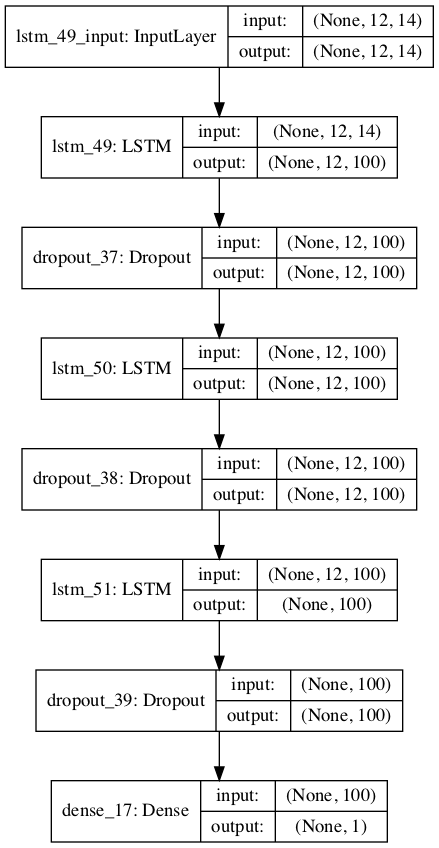

In [20]:
lstm_model = load_model('model/lstm_model_w_low_test_reg_2020_08_31.h5')

# keras.utils.vis_utils.pydot = pydot
plot_model(lstm_model, to_file = 'images/lstm_model.png', show_shapes = True,)# show_layer_names = True)

### The S&P 500 LSTM univariate model

To be able to compare the predicted returns of the company-specific multivariate LSTM model with the predicted S&P 500 returns, a specific LSTM model needs to built. There is no analyst estimates data for the S&P 500 so the model will be a univariate LSTM model. The same hyperparameters will be used as the company-specific model.

In [21]:
def build_spx_lstm_model(
    rate_dropout = 0.2,
    n_nodes_list = (100,100,100),
    n_input = 12,
    lr = 0.0001,
    act_funct = 'relu', 
    loss = 'mean_squared_error'
):

    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    spx_lstm_model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            spx_lstm_model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer], 
                input_shape = (n_input, 1)
            ))
        else:
            spx_lstm_model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer]
            ))
        if rate_dropout != 0.0:
            spx_lstm_model.add(Dropout(rate = rate_dropout))
    
    
    
    spx_lstm_model.add(Dense(1))


    opt = Adam(learning_rate = lr)
    spx_lstm_model.compile(optimizer = opt, loss = loss)
    
    return spx_lstm_model

spx_lstm_model = build_spx_lstm_model()

__There are now 2 approaches to predicting the share prices:__
1. The original trained weights can be used for each company. This means that the model does not need to be retrained at every interval. But it does mean the weights and biases are relevant for every company
2. Alternatively, the model could be retrained every month for the respective company. The hyperparameters would remain the same. 

### Approach 1 - Retraining the model for every month/company

__Steps:__ 
1. Identify the company(s) to be considered for the current month and build the respective dataframe for that company
2. Fit the data to the model using the previous 12 months of data. Or can I use more? Depends on whether there is data history for that company 
3. Predict the next months performance:
    1. for the company(s)
    2. for the S&P 500 
4. Determine which of the 2 is expected to perform better and: 
    1. Take a long position in the better performer
    2. Take a short position in the other
5. Measure the actual performance for the month to compare with the strategies predicted performance. 
6. Compare the strategy's performance to a simple buy-and-hold, by performing a thorough analysis of all the metrics (MDD, Sharpe, etc)


In [22]:
def create_lstm_model(
    n_nodes_list, 
    n_input, 
    n_cols, 
    rate_dropout, 
    lr, 
    act_funct = 'relu', 
    loss = 'mean_squared_error'
):
    
    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer], 
                input_shape = (n_input, n_cols)
            ))
        else:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer]
            ))
        if rate_dropout != 0.0:
            model.add(Dropout(rate = rate_dropout))
            
            
    
    lstm_model.add(Dense(1))
    opt = Adam(learning_rate = lr)
    lstm_model.compile(optimizer = opt, loss = loss)
    
    return lstm_model

_Why can't I just use the predict method without having to retrain the models every month?_

Because the model trained in the hyperparameter search section is unique to the company tested in that isolated case and time period. It is worth training the parameters (ie. weights/biases/gates etc...) for each new company and time period. 

In [23]:
spx_monthly_df = spx_df.resample('M').last()

In [24]:
len(dates) - 48

12

In [25]:
def predict_monthly_returns(
    n_input = 12,
    batch_size = 1,
    epochs = 100, # too few considering the smaller data size? 
    n_nodes_list = (100,100,100),
    rate_dropout = 0.2,
    lr = 0.001
):

    early_stopping = EarlyStopping(monitor = 'loss', patience = 25)

    predictions = []
    spx_predictions = []

    ## Loop through each month
    for m in range(len(dates) - 48):

        ## Identify the company under review and build the dataset
        isin, ric, name, error = best_company_dict[dates[m+48]]
        company_df = build_lstm_dataset(ric, isin)
        company_df = company_df.fillna(method = 'ffill') # some longer dated estimates data can be missing
        train_df = company_df.loc[dates[m]:dates[m+47], :]
        test_df = company_df.loc[dates[m+48], :]
        n_cols = train_df.shape[1]

        ## Create the matching time series data for SPX
        spx_train_df = copy.deepcopy(spx_monthly_df[dates[m]:dates[m+47]])
        spx_test_df = copy.deepcopy(spx_monthly_df[dates[m+48]])

        ## Scale the company data
        scaler = MinMaxScaler()
        scaler.fit(train_df) 
        scaled_train_df = scaler.transform(train_df) 
        scaled_test_df = scaler.transform(test_df)

        ## Scale the SPX data
        spx_scaler = MinMaxScaler()
        spx_scaler.fit(spx_train_df)
        scaled_spx_train_df = spx_scaler.transform(spx_train_df)
        scaled_spx_test_df = spx_scaler.transform(spx_train_df)

        ## Fit the training data to the model
        generator = TimeseriesGenerator(
            scaled_train_df, 
            scaled_train_df[:, 11], 
            length = n_input, 
            batch_size = batch_size
        )
        lstm_model = create_lstm_model(n_nodes_list, n_input, n_cols, rate_dropout, lr)
        lstm_model.fit_generator(
            generator, 
            epochs = epochs, 
            callbacks = [early_stopping]
        )

        # Fit the training data for the SPX model
        spx_generator = TimeseriesGenerator(
            scaled_spx_train_df, 
            scaled_spx_train_df, 
            length = n_input, 
            batch_size = batch_size
        )
        spx_lstm_model.fit_generator(
            spx_generator, 
            epochs = epochs, 
            callbacks = [early_stopping]
        )

        ## Generate Company Predictions
        eval_data = scaled_train_df[-n_input:].reshape((1, n_input, n_cols))
        prediction = lstm_model.predict(eval_data)[0]
        
        prediction_temp = np.zeros((1, 14))
        prediction_temp[:, 11] = prediction
    
        true_prediction = scaler.inverse_transform(prediction_temp.reshape(1, -1))[0]
        return_prediction = true_prediction[11] / train_df.iloc[-1, 11] - 1 # column 11 is 'Price'
        return_actual = test_df.iloc[0, 11] / train_df.iloc[-1, 11] - 1
        predictions.append([dates[m+48], name, return_prediction, return_actual])


        ## Generate SPX Predictions
        spx_eval_data = scaled_spx_train_df[-n_input:].reshape((1, n_input, 1))
        spx_prediction = spx_lstm_model.predict(spx_eval_data)[0]
        spx_true_prediction = spx_scaler.inverse_transform(spx_prediction.reshape(1, -1))[0]
        spx_return_prediction = spx_true_prediction / spx_train_df.iloc[-1] - 1
        spx_predictions.append([dates[m+48], spx_return_prediction])
        
    return predictions, spx_predictions

In [26]:
predictions, spx_predictions = predict_monthly_returns()

(60,) (60, 11)
Epoch 1/100
36/36 [==============================] - 2s 52ms/step - loss: 0.0841
Epoch 2/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0261
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0150
Epoch 4/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0228
Epoch 5/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0183
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0252
Epoch 7/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0246
Epoch 8/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0192
Epoch 9/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0194
Epoch 10/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0172
Epoch 11/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0107
Epoch 12/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0136
Epoch 13/1

36/36 [==============================] - 0s 14ms/step - loss: 0.0079
Epoch 6/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0051
Epoch 7/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0078
Epoch 8/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0039
Epoch 9/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 10/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0055
Epoch 11/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0045
Epoch 12/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0074
Epoch 13/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0074
Epoch 14/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 15/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0024
Epoch 16/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 17/100
36/36 [=============

36/36 [==============================] - 1s 14ms/step - loss: 0.0161
Epoch 25/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0103
Epoch 26/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0114
Epoch 27/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0118
Epoch 28/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0109
Epoch 29/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0079
Epoch 30/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0145
Epoch 31/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0097
Epoch 32/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0138
Epoch 33/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0087
Epoch 34/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0078
Epoch 35/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0116
Epoch 36/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0042
Epoch 46/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 47/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0032
Epoch 48/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0054
Epoch 49/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 50/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 51/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0029
Epoch 52/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0054
Epoch 53/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0079
Epoch 54/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0053
Epoch 55/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0033
Epoch 56/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0030
Epoch 57/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 67/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 68/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 69/100
36/36 [==============================] - 1s 14ms/step - loss: 9.3038e-04
Epoch 70/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 71/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0015
Epoch 72/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0015
Epoch 73/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 74/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 75/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0015
Epoch 76/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 77/100
36/36 [==============================] - 1s 14ms/step - loss: 9.6987e-04
Epoch 78/100
36/36 [=

36/36 [==============================] - 1s 14ms/step - loss: 0.0033
Epoch 43/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0069
Epoch 44/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0029
Epoch 45/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 46/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0033
Epoch 47/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0043
Epoch 48/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 49/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0025
Epoch 50/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0038
Epoch 51/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0030
Epoch 52/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0033
Epoch 53/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0045
Epoch 54/100
36/36 [=========

Epoch 88/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0021
Epoch 1/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 2/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 5/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 6/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 7/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0082
Epoch 8/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 9/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 10/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 11/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 12/100
36/36 [=====

36/36 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 31/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 32/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0032
Epoch 33/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0031
Epoch 34/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 35/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0029
Epoch 36/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0036
Epoch 37/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0054
Epoch 38/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 39/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0029
Epoch 40/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0076
Epoch 41/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0022
Epoch 42/100
36/36 [=========

36/36 [==============================] - 1s 15ms/step - loss: 0.0145
Epoch 53/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0111
Epoch 54/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0083
Epoch 55/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0081
Epoch 56/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0061
Epoch 57/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0050
Epoch 58/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0068
Epoch 59/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0095
Epoch 60/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 61/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0063
Epoch 62/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0107
Epoch 63/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0032
Epoch 64/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0054
Epoch 26/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0082
Epoch 27/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0029
Epoch 28/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 29/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 30/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0037
Epoch 31/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0049
Epoch 32/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0051
Epoch 33/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0060
Epoch 34/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 35/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 36/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 37/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0200
Epoch 23/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0164
Epoch 24/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0198
Epoch 25/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0168
Epoch 26/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0215
Epoch 27/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0138
Epoch 28/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0139
Epoch 29/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0125
Epoch 30/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0173
Epoch 31/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0168
Epoch 32/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0203
Epoch 33/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0165
Epoch 34/100
36/36 [=========

In [27]:
predictions

[['1999-02',
  'American Electric Power Company Inc',
  -0.010078467418055737,
  -0.04992866516113281],
 ['1999-03',
  'American Electric Power Company Inc',
  0.057479628929504756,
  -0.04654651880264282],
 ['1999-04',
  'American Electric Power Company Inc',
  0.0760792161536028,
  0.04409444332122803],
 ['1999-05',
  'American Electric Power Company Inc',
  -0.010944179819719624,
  0.04675722122192383],
 ['1999-06',
  'American Electric Power Company Inc',
  -0.00726429529767203,
  -0.13400578498840332],
 ['1999-07',
  'Progress Energy Inc',
  -0.034893255286086666,
  -0.03924316167831421],
 ['1999-08', 'Progress Energy Inc', 0.047222722924954, -0.11548745632171631],
 ['1999-09',
  'American Electric Power Company Inc',
  0.19475161311138112,
  -0.060240983963012695],
 ['1999-10',
  'American Electric Power Company Inc',
  0.1342224310605955,
  0.010989069938659668],
 ['1999-11',
  'Dominion Energy Inc',
  -0.06073074681418278,
  -0.05714285373687744],
 ['1999-12',
  'American Elect

Now the predicted returns and the actual returns can be collected with a dataframe. This is done for both the company returns and the S&P 500 returns. This allows for a simple check to see if the predicted company return is higher than the predicted S&P return which is an important step in the trading strategy logic. 

In [29]:
test_returns = spx_monthly_df.pct_change().loc[dates[48]:].values.flatten() # 12 month training periof

predictions_df = pd.DataFrame({
    'company_returns_pred': [x[2] for x in predictions], 
    'company_returns_actual': [x[3] for x in predictions],
    'spx_returns_pred': [x[1].values[0] for x in spx_predictions],
    'spx_returns_actual': test_returns
    
    },
    index = [x[0] for x in predictions]
)

predictions_df['long_company'] = predictions_df['company_returns_pred'] > predictions_df['spx_returns_pred']
predictions_df.head()

,company_returns_pred,company_returns_actual,spx_returns_pred,spx_returns_actual,long_company
1999-02,-0.010078,-0.049929,-0.016997,-0.032283,True
1999-03,0.057480,-0.046547,-0.047689,0.038794,True
1999-04,0.076079,0.044094,-0.059484,0.037944,True
1999-05,-0.010944,0.046757,-0.098013,-0.024970,True
1999-06,-0.007264,-0.134006,-0.074911,0.054438,True


With the `predictions_df` dataframe built, it is easy now to determine the trading strategy's performance. For each month, the returns of the long and short positions are grouped together. The net return of the long and short portfolios is then determined to give the overall strategy performance. 

Both the predicted strategy returns and actual strategy returns are calculated. 

In [30]:
long_pred = []
short_pred = [] 
long_act = []
short_act = []

for month in predictions_df.index:
    if predictions_df.loc[month, 'long_company']:
        long_pred.append(predictions_df.loc[month, 'company_returns_pred'])
        short_pred.append(predictions_df.loc[month, 'spx_returns_pred'])
        long_act.append(predictions_df.loc[month, 'company_returns_actual'])
        short_act.append(predictions_df.loc[month, 'spx_returns_actual'])
    else:
        long_pred.append(predictions_df.loc[month, 'spx_returns_pred'])
        short_pred.append(predictions_df.loc[month, 'company_returns_pred'])
        long_act.append(predictions_df.loc[month, 'spx_returns_actual'])
        short_act.append(predictions_df.loc[month, 'company_returns_actual'])
        

predicted_strategy_return_df = pd.DataFrame({
    'Long': long_pred,
    'Short': short_pred,
    'Net': np.array(long_pred) - np.array(short_pred)
    },
    index = predictions_df.index,
)

actual_strategy_return_df = pd.DataFrame({
    'Long': long_act,
    'Short': short_act,
    'Net': np.array(long_act) - np.array(short_act)
    },
    index = predictions_df.index,
)

## Performance Evaluation

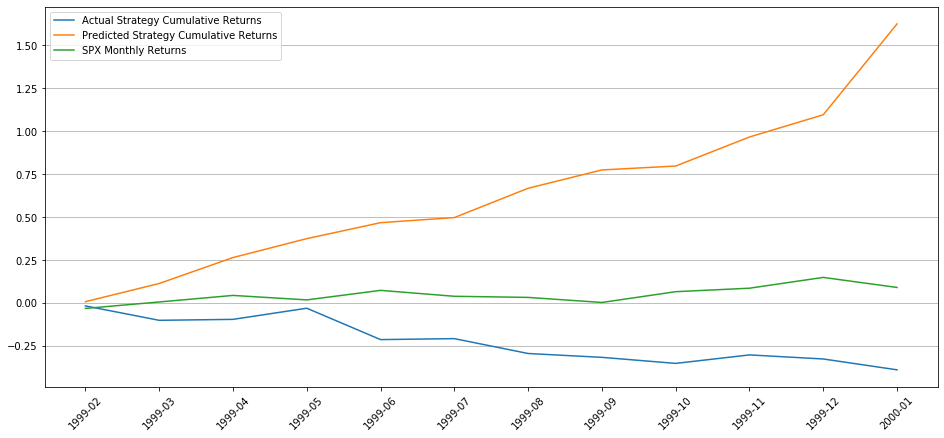

In [36]:
plt.figure(figsize = (16, 7))
plt.plot(np.cumprod(1 + actual_strategy_return_df['Net']) - 1, label = 'Actual Strategy Cumulative Returns')
plt.plot(np.cumprod(1 + predicted_strategy_return_df['Net']) - 1, label = 'Predicted Strategy Cumulative Returns')
plt.plot(np.cumprod(1 + test_returns) - 1, label = 'SPX Monthly Returns')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()

Create some functions to measure the strategy performance by the various metrics discussed in the State-of-the-Art section. The metrics are Maximum Drawdown, Maximum Drawdown duration, APR, Sharpe Ratio and the Pearson correlation.

In [32]:
def apr(ts):
    return np.prod(1 + ts) ** (12 / len(ts)) - 1 
    
def sharpe(ts):
    return np.sqrt(12) * np.mean(ts) / np.std(ts)

def max_dd(ts):
    cum_ret = np.cumprod(1 + ts) - 1
    
    high_water_mark = np.zeros(cum_ret.shape)
    draw_down = np.zeros(cum_ret.shape)
    draw_down_duration = np.zeros(cum_ret.shape)
    
    for t in np.arange(1, cum_ret.shape[0]):
        high_water_mark[t] = np.maximum(high_water_mark[t - 1], cum_ret[t])
        draw_down[t] = (1 + cum_ret[t]) / (1 + high_water_mark[t]) - 1
        if draw_down[t] == 0:
            draw_down_duration[t] = 0
        else:
            draw_down_duration[t] = draw_down_duration[t - 1] + 1 # adds another day
    
    max_dd, i = np.min(draw_down), np.argmin(draw_down) # 'draw_down' < 0 always
    max_ddd = np.max(draw_down_duration)
    
    return max_dd, max_ddd, i

In [33]:
perf_metrics_df = pd.DataFrame()

perf_metrics_df.loc['APR', 'Strategy'] = apr(actual_strategy_return_df['Net'])
perf_metrics_df.loc['APR', 'S&P'] = apr(test_returns)
perf_metrics_df.loc['Sharpe_Ratio', 'Strategy'] = sharpe(actual_strategy_return_df['Net'])
perf_metrics_df.loc['Sharpe_Ratio', 'S&P'] = sharpe(test_returns)
perf_metrics_df.loc['Max_DD', 'Strategy'] = max_dd(actual_strategy_return_df['Net'])[0]
perf_metrics_df.loc['Max_DD', 'S&P'] = max_dd(test_returns)[0]
perf_metrics_df.loc['Max_DD_Duration', 'Strategy'] = max_dd(actual_strategy_return_df['Net'])[1]
perf_metrics_df.loc['Max_DD_Duration', 'S&P'] = max_dd(test_returns)[1]

perf_metrics_df

,Strategy,S&P
APR,-0.389523,0.089728
Sharpe_Ratio,-1.797080,0.695391
Max_DD,-0.389523,-0.065564
Max_DD_Duration,11.000000,4.000000


It could be the case that the strategy out/underperformed by luck. It is also useful to measure how well the strategy performed vs its predicted performance, much in the same way the autoencoder and lstm models were originally assessed. 

A useful metric for this analysis could be to consider the MSE, although this may offer little information on its own. However if different models were to be created, such as different mixes of companies, it might be useful to compare MSE between the different strategies. 

It might also be useful to perform a t-test to determine whether the difference between the mean of the predicted strategy returns and the mean of the actual strategy returns is statistically significant. 

https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

In [57]:
strategy_mse = mean_squared_error(actual_strategy_return_df['Net'], predicted_strategy_return_df['Net'])
strategy_mse

TypeError: 'numpy.float64' object is not callable

In [35]:
t_stat, p_val = stats.ttest_ind(actual_strategy_return_df['Net'], predicted_strategy_return_df['Net'])
t_stat, p_val # a large p-value indicates the actual and predicted are not the same at 95%

(-4.234908033951054, 0.00033993685450012647)

## Again, without dropout rate

In [37]:
spx_lstm_model2 = build_spx_lstm_model(rate_dropout = 0.0)
predictions2, spx_predictions2 = predict_monthly_returns(rate_dropout = 0.0)

(60,) (60, 11)
Epoch 1/100
36/36 [==============================] - 3s 77ms/step - loss: 1.2843
Epoch 2/100
36/36 [==============================] - 1s 21ms/step - loss: 0.9354
Epoch 3/100
36/36 [==============================] - 1s 20ms/step - loss: 0.6972
Epoch 4/100
36/36 [==============================] - 1s 19ms/step - loss: 0.3697
Epoch 5/100
36/36 [==============================] - 1s 18ms/step - loss: 0.2259
Epoch 6/100
36/36 [==============================] - 1s 18ms/step - loss: 0.1367
Epoch 7/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0770
Epoch 8/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0476
Epoch 9/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0749
Epoch 10/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0694
Epoch 11/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0746
Epoch 12/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0455
Epoch 13/1

36/36 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 33/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0027
Epoch 34/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0033
Epoch 35/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0032
Epoch 36/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0023
Epoch 37/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0032
Epoch 38/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 39/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0022
Epoch 40/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0044
Epoch 41/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 42/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0101
Epoch 43/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0089
Epoch 44/100
36/36 [=========

36/36 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 23/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 24/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0049
Epoch 25/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 26/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 27/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0028
Epoch 28/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0041
Epoch 29/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 30/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0034
Epoch 31/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0044
Epoch 32/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0045
Epoch 33/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0055
Epoch 34/100
36/36 [=========

36/36 [==============================] - 1s 17ms/step - loss: 0.0149
Epoch 37/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0067
Epoch 38/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0041
Epoch 39/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 40/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0029
Epoch 41/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0045
Epoch 42/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0034
Epoch 43/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0038
Epoch 44/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0054
Epoch 45/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0068
Epoch 46/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 47/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 48/100
36/36 [=========

Epoch 88/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0053
Epoch 89/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0090
Epoch 90/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0067
Epoch 91/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0108
Epoch 92/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0078
Epoch 93/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0082
Epoch 94/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0058
Epoch 95/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0077
Epoch 96/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0096
Epoch 97/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0106
Epoch 98/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 99/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0078
Epoch 100/100
36

Epoch 38/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0129
Epoch 39/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0286
Epoch 40/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0153
Epoch 41/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0208
Epoch 42/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0326
Epoch 43/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0442
Epoch 44/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0209
Epoch 45/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0128
Epoch 46/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0183
Epoch 47/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0175
Epoch 48/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0203
Epoch 49/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0242
Epoch 50/100
36/

Epoch 26/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0304
Epoch 27/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0266
Epoch 28/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0212
Epoch 29/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0265
Epoch 30/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0193
Epoch 31/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0407
Epoch 32/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0580
Epoch 33/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0671
Epoch 34/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0654
Epoch 35/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0631
Epoch 36/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0601
Epoch 37/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0606
Epoch 38/100
36/

36/36 [==============================] - 0s 13ms/step - loss: 0.0034
Epoch 12/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0066
Epoch 13/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 14/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0038
Epoch 15/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 16/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 17/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 18/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 19/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 20/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 21/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0047
Epoch 22/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 23/100
36/36 [=========

Epoch 75/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0403
Epoch 76/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0348
Epoch 77/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0396
Epoch 78/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0409
Epoch 1/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 2/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 3/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0071
Epoch 6/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 7/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 8/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0072
Epoch 9/100
36/36 [=====

Epoch 55/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0581
Epoch 56/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0581
Epoch 57/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0581
Epoch 58/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0582
Epoch 59/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0582
Epoch 60/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0581
Epoch 61/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0581
Epoch 62/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0583
Epoch 63/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0581
Epoch 64/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0581
Epoch 65/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0581
Epoch 66/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0581
Epoch 67/100
36/

Epoch 27/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0081
Epoch 28/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0292
Epoch 29/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0406
Epoch 30/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0227
Epoch 31/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0238
Epoch 32/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0338
Epoch 33/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0243
Epoch 34/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0158
Epoch 35/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0194
Epoch 36/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0368
Epoch 37/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0337
Epoch 38/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0255
Epoch 39/100
36/

In [38]:
test_returns = spx_monthly_df.pct_change().loc[dates[48]:].values.flatten() # 12 month training periof

predictions_df2 = pd.DataFrame({
    'company_returns_pred': [x[2] for x in predictions2], 
    'company_returns_actual': [x[3] for x in predictions2],
    'spx_returns_pred': [x[1].values[0] for x in spx_predictions2],
    'spx_returns_actual': test_returns
    
    },
    index = [x[0] for x in predictions2]
)

predictions_df2['long_company'] = predictions_df2['company_returns_pred'] > predictions_df2['spx_returns_pred']
predictions_df2.head()

,company_returns_pred,company_returns_actual,spx_returns_pred,spx_returns_actual,long_company
1999-02,-0.031621,-0.049929,-0.052649,-0.032283,True
1999-03,0.026642,-0.046547,0.019231,0.038794,True
1999-04,0.063850,0.044094,-0.053131,0.037944,True
1999-05,0.028500,0.046757,-0.017217,-0.024970,True
1999-06,-0.027022,-0.134006,-0.025303,0.054438,False


In [39]:
long_pred2 = []
short_pred2 = [] 
long_act2 = []
short_act2 = []

for month in predictions_df2.index:
    if predictions_df2.loc[month, 'long_company']:
        long_pred2.append(predictions_df2.loc[month, 'company_returns_pred'])
        short_pred2.append(predictions_df2.loc[month, 'spx_returns_pred'])
        long_act2.append(predictions_df2.loc[month, 'company_returns_actual'])
        short_act2.append(predictions_df2.loc[month, 'spx_returns_actual'])
    else:
        long_pred2.append(predictions_df2.loc[month, 'spx_returns_pred'])
        short_pred2.append(predictions_df2.loc[month, 'company_returns_pred'])
        long_act2.append(predictions_df2.loc[month, 'spx_returns_actual'])
        short_act2.append(predictions_df2.loc[month, 'company_returns_actual'])
        

predicted_strategy_return_df2 = pd.DataFrame({
    'Long': long_pred2,
    'Short': short_pred2,
    'Net': np.array(long_pred2) - np.array(short_pred2)
    },
    index = predictions_df2.index,
)

actual_strategy_return_df2 = pd.DataFrame({
    'Long': long_act2,
    'Short': short_act2,
    'Net': np.array(long_act2) - np.array(short_act2)
    },
    index = predictions_df2.index,
)

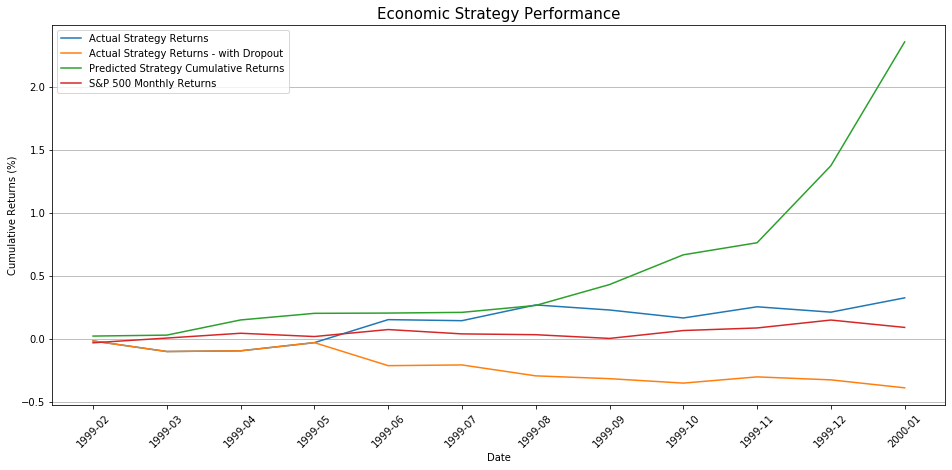

In [66]:
plt.figure(figsize = (16, 7))
plt.plot(np.cumprod(1 + actual_strategy_return_df2['Net']) - 1, label = 'Actual Strategy Returns')
plt.plot(np.cumprod(1 + actual_strategy_return_df['Net']) - 1, label = 'Actual Strategy Returns - with Dropout')
plt.plot(np.cumprod(1 + predicted_strategy_return_df2['Net']) - 1, label = 'Predicted Strategy Cumulative Returns')
plt.plot(np.cumprod(1 + test_returns) - 1, label = 'S&P 500 Monthly Returns')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.title('Economic Strategy Performance', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.show()

In [52]:
np.corrcoef(actual_strategy_return_df2['Net'], test_returns)[0,1]

array([[ 1.        , -0.12607831],
       [-0.12607831,  1.        ]])

In [54]:
perf_metrics_df2 = pd.DataFrame()

perf_metrics_df2.loc['APR', 'Strategy'] = apr(actual_strategy_return_df2['Net'])
perf_metrics_df2.loc['APR', 'Strategy - with DO'] = apr(actual_strategy_return_df['Net'])
perf_metrics_df2.loc['APR', 'S&P'] = apr(test_returns)
perf_metrics_df2.loc['Sharpe_Ratio', 'Strategy'] = sharpe(actual_strategy_return_df2['Net'])
perf_metrics_df2.loc['Sharpe_Ratio', 'Strategy - with DO'] = sharpe(actual_strategy_return_df['Net'])
perf_metrics_df2.loc['Sharpe_Ratio', 'S&P'] = sharpe(test_returns)
perf_metrics_df2.loc['Max_DD', 'Strategy'] = max_dd(actual_strategy_return_df2['Net'])[0]
perf_metrics_df2.loc['Max_DD', 'Strategy - with DO'] = max_dd(actual_strategy_return_df['Net'])[0]
perf_metrics_df2.loc['Max_DD', 'S&P'] = max_dd(test_returns)[0]
perf_metrics_df2.loc['Max_DD_Duration', 'Strategy'] = max_dd(actual_strategy_return_df2['Net'])[1]
perf_metrics_df2.loc['Max_DD_Duration', 'Strategy - with DO'] = max_dd(actual_strategy_return_df['Net'])[1]
perf_metrics_df2.loc['Max_DD_Duration', 'S&P'] = max_dd(test_returns)[1]
perf_metrics_df2.loc['Correlation', 'Strategy'] = np.corrcoef(actual_strategy_return_df2['Net'], test_returns)[0,1]
perf_metrics_df2.loc['Correlation', 'Strategy - with DO'] = np.corrcoef(actual_strategy_return_df['Net'], test_returns)[0,1]
perf_metrics_df2.loc['Correlation', 'S&P'] = np.corrcoef(test_returns, test_returns)[0,1]

perf_metrics_df2

,Strategy,Strategy - with DO,S&P
APR,0.324243,-0.389523,0.089728
Sharpe_Ratio,1.191796,-1.797080,0.695391
Max_DD,-0.101481,-0.389523,-0.065564
Max_DD_Duration,4.000000,11.000000,4.000000
Correlation,-0.126078,-0.248968,1.000000


In [55]:
perf_metrics_df2.to_csv('../Data/1995-2000_strategy_performance.csv')

In [65]:
strategy_mse2 = mean_squared_error(actual_strategy_return_df2['Net'], predicted_strategy_return_df2['Net'])
strategy_mse2, strategy_mse

(0.03196383512904123, 0.026074109593040528)

In [63]:
from sklearn.metrics import r2_score

lstmdo_r2 = r2_score(actual_strategy_return_df['Net'], predicted_strategy_return_df['Net'])
lstm_r2 = r2_score(actual_strategy_return_df2['Net'], predicted_strategy_return_df2['Net'])

lstmdo_r2, lstm_r2

(-3.984043874902368, -4.384066453329405)

In [64]:
t_stat, p_val # a large p-value indicates the actual and predicted are not the same at 95%

(-4.234908033951054, 0.00033993685450012647)

In [43]:
t_stat2, p_val2 = stats.ttest_ind(actual_strategy_return_df2['Net'], predicted_strategy_return_df2['Net'])
t_stat2, p_val2 # a large p-value indicates the actual and predicted are not the same at 95%

(-1.895857499402101, 0.07119090497667988)

In [60]:
predicted_strategy_return_df['Net']

1999-02    0.006919
1999-03    0.105168
1999-04    0.135563
1999-05    0.087069
1999-06    0.067646
1999-07    0.020208
1999-08    0.114017
1999-09    0.063973
1999-10    0.012855
1999-11    0.094064
1999-12    0.065692
2000-01    0.252521
Name: Net, dtype: float64

In [67]:
predictions_df2

,company_returns_pred,company_returns_actual,spx_returns_pred,spx_returns_actual,long_company
1999-02,-0.031621,-0.049929,-0.052649,-0.032283,True
1999-03,0.026642,-0.046547,0.019231,0.038794,True
1999-04,0.063850,0.044094,-0.053131,0.037944,True
1999-05,0.028500,0.046757,-0.017217,-0.024970,True
1999-06,-0.027022,-0.134006,-0.025303,0.054438,False
1999-07,-0.026010,-0.039243,-0.030672,-0.032046,True
1999-08,0.003519,-0.115487,0.048974,-0.006254,False
1999-09,0.213718,-0.060241,0.082723,-0.028552,True
1999-10,0.277027,0.010989,0.111934,0.062540,True
1999-11,-0.109987,-0.057143,-0.052501,0.019062,False


In [70]:
lstm_preds_class = predictions_df2['company_returns_pred'] > predictions_df2['spx_returns_pred']
lstm_act_class = predictions_df2['company_returns_actual'] > predictions_df2['spx_returns_actual']

In [71]:
lstmdo_preds_class = predictions_df['company_returns_pred'] > predictions_df['spx_returns_pred']
lstmdo_act_class = predictions_df['company_returns_actual'] > predictions_df['spx_returns_actual']

In [73]:
confusion_matrix(lstm_act_class, lstm_preds_class)

array([[3, 6],
       [0, 3]])

In [80]:
lstm_acc = accuracy_score(lstm_act_class, lstm_preds_class)
lstm_pre = precision_score(lstm_act_class, lstm_preds_class)
lstm_rec = recall_score(lstm_act_class, lstm_preds_class)

lstm_acc, lstm_pre, lstm_rec

(0.5, 0.3333333333333333, 1.0)

In [74]:
confusion_matrix(lstmdo_act_class, lstmdo_preds_class)

array([[2, 7],
       [1, 2]])

In [81]:
lstmdo_acc = accuracy_score(lstmdo_act_class, lstmdo_preds_class)
lstmdo_pre = precision_score(lstmdo_act_class, lstmdo_preds_class)
lstmdo_rec = recall_score(lstmdo_act_class, lstmdo_preds_class)

lstmdo_acc, lstmdo_pre, lstmdo_rec

(0.3333333333333333, 0.2222222222222222, 0.6666666666666666)